In [1]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf

In [2]:
def get_2d_cnn_model(inpt_shape, avg_pooling=False, max_pooling=False, strd_conv=False):
  """
  Returns a 2D-CNN model for image classification.

  Args:
    input_shape <tuple>: A tuple of 2D image shape e.g. (32, 32, 3)
  """
  def _get_cnn_block(layer, num_filters, layer_objs_lst):
    conv = tf.keras.layers.Conv2D(
        num_filters, 3, padding="same", activation="relu",
        kernel_initializer="he_uniform",
        kernel_regularizer=tf.keras.regularizers.l2(0.005))(layer)
    if avg_pooling:
      pool = tf.keras.layers.AveragePooling2D()(conv)
    elif max_pooling:
      pool = tf.keras.layers.MaxPooling2D()(conv)
    elif strd_conv:
      pool = tf.keras.layers.Conv2D(
        num_filters, 2, padding="same", #activation="relu",
        kernel_initializer="he_uniform", strides=(2, 2),
        kernel_regularizer=tf.keras.regularizers.l2(0.005))(conv)
      
    layer_objs_lst.append(conv)
    return pool

  layer_objs_lst = [] # To store the layer objects to probe later in Nengo-DL

  inpt_layer = tf.keras.Input(shape=inpt_shape)
  layer_objs_lst.append(inpt_layer)

  layer = _get_cnn_block(inpt_layer, 32, layer_objs_lst)
  layer = _get_cnn_block(layer, 64, layer_objs_lst)
  layer = _get_cnn_block(layer, 128, layer_objs_lst)

  flat = tf.keras.layers.Flatten()(layer)

  dense = tf.keras.layers.Dense(
      512, activation="relu", kernel_initializer="he_uniform",
      kernel_regularizer=tf.keras.regularizers.l2(0.005))(flat)
  layer_objs_lst.append(dense)

  output_layer = tf.keras.layers.Dense(
      10, activation="softmax", kernel_initializer="he_uniform",
      kernel_regularizer=tf.keras.regularizers.l2(0.005))(dense)
  layer_objs_lst.append(output_layer)

  model = tf.keras.Model(inputs=inpt_layer, outputs=output_layer)
  return model, layer_objs_lst

In [3]:
model, layer_objs_lst = get_2d_cnn_model((32, 32, 3), avg_pooling=True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 128)         0     

In [6]:
ndl_model = nengo_dl.Converter(
    model,
    swap_activations={
        tf.keras.activations.relu: nengo.SpikingRectifiedLinear()},
    scale_firing_rates=20,
    synapse=0.005,
    inference_only=True)

In [7]:
ndl_model.net.all_ensembles

[<Ensemble "conv2d.0" at 0x2b253f1e8510>,
 <Ensemble "conv2d_1.0" at 0x2b253f557e10>,
 <Ensemble "conv2d_2.0" at 0x2b253f3237d0>,
 <Ensemble "dense.0" at 0x2b253f372050>]

In [8]:
ndl_model.net.all_nodes

[<Node "input_1" at 0x2b253f557510>,
 <Node "conv2d.0.bias" at 0x2b253f557710>,
 <Node "conv2d.0.bias_relay" at 0x2b253f557750>,
 <Node "average_pooling2d.0" at 0x2b253f557a90>,
 <Node "conv2d_1.0.bias" at 0x2b253f557fd0>,
 <Node "conv2d_1.0.bias_relay" at 0x2b253f323050>,
 <Node "average_pooling2d_1.0" at 0x2b253f3234d0>,
 <Node "conv2d_2.0.bias" at 0x2b253f323990>,
 <Node "conv2d_2.0.bias_relay" at 0x2b253f3239d0>,
 <Node "average_pooling2d_2.0" at 0x2b253f323d50>,
 <TensorNode "dense_1.0" at 0x2b253f3722d0>,
 <Node "dense_1.0.bias" at 0x2b253f372390>]

In [3]:
model, layer_objs_lst = get_2d_cnn_model((32, 32, 3), max_pooling=True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0     

In [4]:
ndl_model = nengo_dl.Converter(
    model,
    swap_activations={
        tf.keras.activations.relu: nengo.SpikingRectifiedLinear()},
    scale_firing_rates=20,
    synapse=0.005,
    inference_only=True)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:326: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  % (error_msg + ". " if error_msg else "")
/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2ad4b0601b00> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [5]:
ndl_model.net.all_ensembles

[<Ensemble "conv2d.0" at 0x2ad4b26bc310>,
 <Ensemble "conv2d_1.0" at 0x2ad4b76b1b90>,
 <Ensemble "conv2d_2.0" at 0x2ad4b748f4d0>,
 <Ensemble "dense.0" at 0x2ad4b7685290>]

In [6]:
ndl_model.net.all_nodes

[<Node "input_1" at 0x2ad4b72e1cd0>,
 <Node "conv2d.0.bias" at 0x2ad4b72e1150>,
 <Node "conv2d.0.bias_relay" at 0x2ad4b46dc910>,
 <TensorNode "max_pooling2d" at 0x2ad4b76b1850>,
 <Node "conv2d_1.0.bias" at 0x2ad4b76b1ad0>,
 <Node "conv2d_1.0.bias_relay" at 0x2ad4b76b1c10>,
 <TensorNode "max_pooling2d_1" at 0x2ad4b748f150>,
 <Node "conv2d_2.0.bias" at 0x2ad4b748f810>,
 <Node "conv2d_2.0.bias_relay" at 0x2ad4b748f890>,
 <TensorNode "max_pooling2d_2" at 0x2ad4b748ff50>,
 <TensorNode "dense_1.0" at 0x2ad4b7685450>,
 <Node "dense_1.0.bias" at 0x2ad4b7685510>]

In [3]:
model, layer_objs_lst = get_2d_cnn_model((32, 32, 3), strd_conv=True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          16448     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         65664 

In [4]:
ndl_model = nengo_dl.Converter(
    model,
    swap_activations={
        tf.keras.activations.relu: nengo.SpikingRectifiedLinear()},
    scale_firing_rates=20,
    synapse=0.005,
    inference_only=True)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2b546b843b90> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [5]:
ndl_model.net.all_ensembles

[<Ensemble "conv2d.0" at 0x2b546f930850>,
 <Ensemble "conv2d_2.0" at 0x2b547656cd10>,
 <Ensemble "conv2d_4.0" at 0x2b5476593950>,
 <Ensemble "dense.0" at 0x2b54765974d0>]

In [6]:
ndl_model.net.all_nodes

[<Node "input_1" at 0x2b546b11d050>,
 <Node "conv2d.0.bias" at 0x2b53eb601310>,
 <Node "conv2d.0.bias_relay" at 0x2b53eb601250>,
 <Node "conv2d_1.0" at 0x2b547654ba10>,
 <Node "conv2d_1.0.bias" at 0x2b547656c7d0>,
 <Node "conv2d_1.0.bias_relay" at 0x2b547656c850>,
 <Node "conv2d_2.0.bias" at 0x2b547656cf10>,
 <Node "conv2d_2.0.bias_relay" at 0x2b547656cf50>,
 <Node "conv2d_3.0" at 0x2b5476593350>,
 <Node "conv2d_3.0.bias" at 0x2b5476593390>,
 <Node "conv2d_3.0.bias_relay" at 0x2b5476593410>,
 <Node "conv2d_4.0.bias" at 0x2b5476593b50>,
 <Node "conv2d_4.0.bias_relay" at 0x2b5476593b90>,
 <Node "conv2d_5.0" at 0x2b5476593f90>,
 <Node "conv2d_5.0.bias" at 0x2b5476597090>,
 <Node "conv2d_5.0.bias_relay" at 0x2b54765970d0>,
 <TensorNode "dense_1.0" at 0x2b5476597890>,
 <Node "dense_1.0.bias" at 0x2b5476551650>]

In [10]:
import pandas as pd

In [12]:
df = pd.DataFrame(np.random.rand(100, 128))
df.shape

(100, 128)

In [5]:
def generate_signal(t):
  """
  t <float>: The time-step of the simulation, e.g. 0.001, 0.002, etc.
  """
  dt = 1e-3 # The time-step duration in nengo.Simulator().
  col_idx = int(t * 1/dt)
  return df.iloc[0, col_idx]

In [7]:
with nengo.Network() as net:
  inp_node = nengo.Node(output=generate_signal)
  inp_node_probe = nengo.Probe(inp_node)

with nengo.Simulator(net, dt=1e-3) as sim:
  sim.run(0.127)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Simulation Time-step')

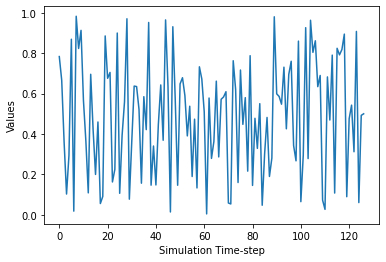

In [14]:
plt.plot(sim.data[inp_node_probe])
plt.ylabel("Values")
plt.xlabel("Simulation Time-step")